# Introduction

In this notebook, I'll explore the TPS Jan 2022 dataset in order to forecast the sales of certain products from two stores. Several feature engineering techniques are reviewed (especially the interaction betweeen features performed in this [notebook](https://www.kaggle.com/lucamassaron/kaggle-merchandise-eda-with-baseline-linear-model/notebook) by [Luca Massaron](https://www.kaggle.com/lucamassaron)).

# Libraries and data

In [1]:
# Libraries needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing the train and test datasets
train = pd.read_csv("train.csv", parse_dates=['date'])
test = pd.read_csv("test.csv", parse_dates=['date'])

# Obtaining the full dataset with a label train/test
full_df = pd.concat([train.assign(dataset='train'), test.assign(dataset='test')])

# Notice we get NaN values for the unknown sales of the test dataset
full_df

row_id       date  country       store         product  num_sold dataset
0          0 2015-01-01  Finland  KaggleMart      Kaggle Mug     329.0   train
1          1 2015-01-01  Finland  KaggleMart      Kaggle Hat     520.0   train
2          2 2015-01-01  Finland  KaggleMart  Kaggle Sticker     146.0   train
3          3 2015-01-01  Finland  KaggleRama      Kaggle Mug     572.0   train
4          4 2015-01-01  Finland  KaggleRama      Kaggle Hat     911.0   train
...      ...        ...      ...         ...             ...       ...     ...
6565   32863 2019-12-31   Sweden  KaggleMart      Kaggle Hat       NaN    test
6566   32864 2019-12-31   Sweden  KaggleMart  Kaggle Sticker       NaN    test
6567   32865 2019-12-31   Sweden  KaggleRama      Kaggle Mug       NaN    test
6568   32866 2019-12-31   Sweden  KaggleRama      Kaggle Hat       NaN    test
6569   32867 2019-12-31   Sweden  KaggleRama  Kaggle Sticker       NaN    test

[32868 rows x 7 columns]

Let's quickly confirm what countries, store and products belong to this dataset.

In [3]:
print('Countries:', full_df['country'].unique().tolist())
print('Stores:', full_df['store'].unique().tolist())
print('Products:', full_df['product'].unique().tolist())

Countries: ['Finland', 'Norway', 'Sweden']
Stores: ['KaggleMart', 'KaggleRama']
Products: ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']


In order to be sure which years we're working on, let's create a 'year' column from the date timestamps.

In [4]:
full_df['year'] = full_df['date'].apply(lambda date: date.year) 
full_df['year'].unique()

array([2015, 2016, 2017, 2018, 2019])

It should be noted that the dates are already sorted and include all days from 2015 to 2019. To confirm this, we can generate a timestamp for every day in these years with pandas, and then compare it to our date columns.

In [5]:
# Array of all days from the first day of 2015 to the last day of 2019
days_range = pd.date_range(start='2015-01-01', end='2019-12-31')

# Is this equal to the (unique) dates from our date column?
(days_range != full_df['date'].unique()).sum()

# Amount of falses is zero:

0

We're also provided with the GDP of the three countries during these years. In previous versions, I used the GDP values provided by [Carl McBride](https://www.kaggle.com/carlmcbrideellis/gdp-20152019-finland-norway-and-sweden). 

In this version, however, I use the GDP per capita dataset by [Samuel Cortinhas](https://www.kaggle.com/samuelcortinhas/gdp-per-capita-finland-norway-sweden-201519), as it has improved the score by a bit.

In [6]:
gdp = pd.read_csv('GDP_per_capita_2015_to_2019_Finland_Norway_Sweden.csv')
gdp.columns = ['year', 'GDP_Finland', 'GDP_Norway', 'GDP_Sweden']
gdp

year  GDP_Finland  GDP_Norway  GDP_Sweden
0  2015        42802       74356       51545
1  2016        43814       70461       51965
2  2017        46412       75497       53792
3  2018        50038       82268       54589
4  2019        48712       75826       51687

# Exploratory Data Analysis

First, we want to make sure which years correspond to the train dataset, and which years to the test dataset.

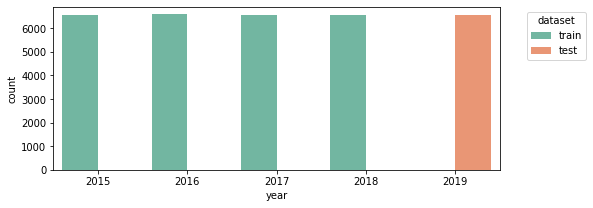

In [7]:
plt.figure(figsize=(8,3))
sns.countplot(data=full_df, x='year', hue='dataset', palette='Set2')
plt.legend(title='dataset', bbox_to_anchor=(1.05, 1));

From the above result, we see that it would be a good idea to train our model on the years 2015, 2016 and 2017 and then evaluate it on 2018 as a hold-out test set.

Let's first see what the sales look like between the three available products.

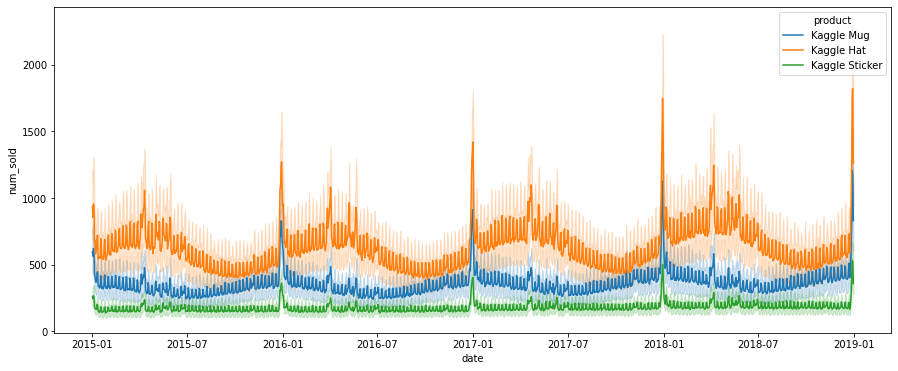

In [8]:
plt.figure(figsize=(15,6))
sns.lineplot(data=full_df[full_df['year']<2019], x='date', y='num_sold', hue='product');

From the above graph, we can clearly infer that there's a certain sales seasonality, and that we can order the amounf of sales as Hat > Mug > Sticker.

Also, we should check if a store sells more than the other two.

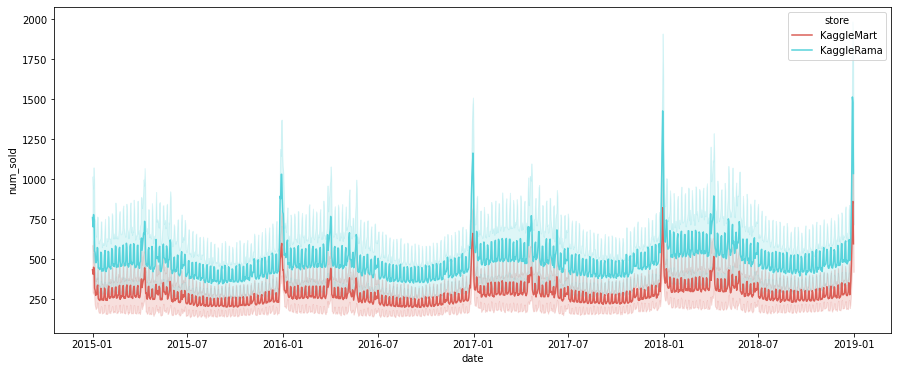

In [9]:
plt.figure(figsize=(15,6))
sns.lineplot(data=full_df[full_df['year']<2019], x='date', y='num_sold', hue='store', palette='hls');

So it seems that KaggleRama sells more products than KaggleMart.

We should also check how the sales differ from one country to another.

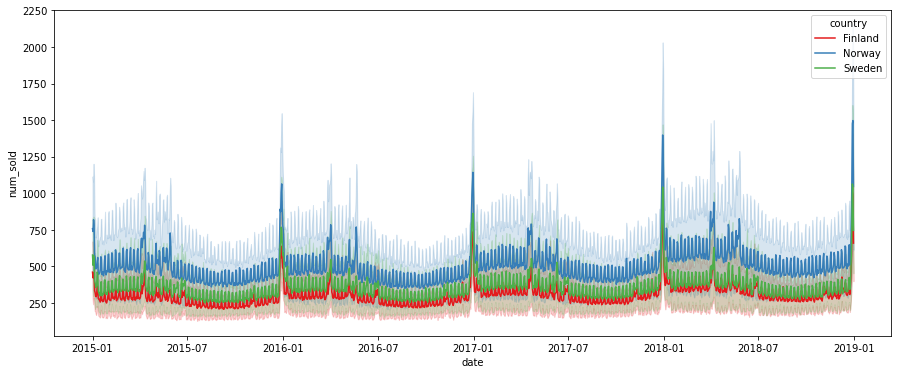

In [10]:
plt.figure(figsize=(15,6))
sns.lineplot(data=full_df[full_df['year']<2019], x='date', y='num_sold', hue='country', palette='Set1');

We see that it's pretty much Norway > Sweden > Finland, regarding the amount of sales by country. 

# Feature Engineering

Since the seasonily is important, we should get as much information as possible from the date column, such as year (which we already did), month, week, day of the month and day of the week.

In [11]:
full_df['month'] = full_df['date'].dt.month
full_df['week'] = full_df['date'].dt.isocalendar().week
full_df['week'][full_df['week']>52] = 52
full_df['day'] = full_df['date'].dt.day
full_df['dayofweek'] = full_df['date'].dt.dayofweek

full_df.head()

row_id       date  country       store         product  num_sold dataset  \
0       0 2015-01-01  Finland  KaggleMart      Kaggle Mug     329.0   train   
1       1 2015-01-01  Finland  KaggleMart      Kaggle Hat     520.0   train   
2       2 2015-01-01  Finland  KaggleMart  Kaggle Sticker     146.0   train   
3       3 2015-01-01  Finland  KaggleRama      Kaggle Mug     572.0   train   
4       4 2015-01-01  Finland  KaggleRama      Kaggle Hat     911.0   train   

   year  month  week  day  dayofweek  
0  2015      1     1    1          3  
1  2015      1     1    1          3  
2  2015      1     1    1          3  
3  2015      1     1    1          3  
4  2015      1     1    1          3

Next, we want to create interactions between features. To understand how this works, first pick up a couple of rows as an example:

In [12]:
rows_example = full_df.iloc[:2]
rows_example

row_id       date  country       store     product  num_sold dataset  year  \
0       0 2015-01-01  Finland  KaggleMart  Kaggle Mug     329.0   train  2015   
1       1 2015-01-01  Finland  KaggleMart  Kaggle Hat     520.0   train  2015   

   month  week  day  dayofweek  
0      1     1    1          3  
1      1     1    1          3

Say we want to create interactions between three features: country, product and month. For every row, we will join their (string) values along the mentioned columns (features).

In [13]:
# Features we want to interact between each other
features_example = ['country', 'product', 'month']

# For the two selected rows, join their respective values
interactions = rows_example[features_example].apply(lambda row: '_'.join(row.astype(str)), axis=1)
interactions

0    Finland_Kaggle Mug_1
1    Finland_Kaggle Hat_1
dtype: object

In [14]:
# One-hot encode them
pd.get_dummies(interactions)

Finland_Kaggle Hat_1  Finland_Kaggle Mug_1
0                     0                     1
1                     1                     0

If we select the rows' features we're interested in, and concat them to the above frame, we get something like this:

In [15]:
pd.concat((rows_example[features_example], pd.get_dummies(interactions)), axis=1)

country     product  month  Finland_Kaggle Hat_1  Finland_Kaggle Mug_1
0  Finland  Kaggle Mug      1                     0                     1
1  Finland  Kaggle Hat      1                     1                     0

In other words, since the first row satisfies having Finland as the country, Kaggle Mug as the product and month equal to 1 (January), it gets a 1 (one) in the 'Finland_Kaggle Mug_1' column, but a 0 in the Kaggle Hat column, whereas the second row gets a 1 there.

Now, to the real work, we will create four interactions and perform the process on the full dataframe as follows. 
(Also, keep in mind that too many interactions can result in overfit when training the model, as I found out when I was testing this, as well as an insanely long time training the model.)

In [16]:
desired_interactions = [
        ['country', 'product', 'month'],
        ['country', 'product', 'week'],
        ['country', 'store', 'week'],
        ['country', 'product', 'month', 'day'],
        ]

for interaction in desired_interactions:
    
    interaction_features = full_df[interaction].apply(lambda row: '_'.join(row.astype(str)), axis=1)
    interaction_features = pd.get_dummies(interaction_features)
    
    full_df = pd.concat((full_df, interaction_features), axis=1)

It should be noted that it may appear that we get columns with the same name, because the month and week values can overlap as in the following example (first month (1) plus first week (1)). But this isn't directly a problem so we leave it as is. 

In [17]:
full_df[['country', 'product', 'month', 'week', 'Finland_Kaggle Hat_1']].head()

country         product  month  week  Finland_Kaggle Hat_1  \
0  Finland      Kaggle Mug      1     1                     0   
1  Finland      Kaggle Hat      1     1                     1   
2  Finland  Kaggle Sticker      1     1                     0   
3  Finland      Kaggle Mug      1     1                     0   
4  Finland      Kaggle Hat      1     1                     1   

   Finland_Kaggle Hat_1  
0                     0  
1                     1  
2                     0  
3                     0  
4                     1

We will now add the GDP values of each country. Remember we had the GDP dataset:

In [18]:
gdp

year  GDP_Finland  GDP_Norway  GDP_Sweden
0  2015        42802       74356       51545
1  2016        43814       70461       51965
2  2017        46412       75497       53792
3  2018        50038       82268       54589
4  2019        48712       75826       51687

We will create three new columns 'GDP_Finland', 'GDP_Norway', 'GDP_Sweden" such that their values will be either zero or the corresponding GDP value if the country and the year match with those of the row.

In [19]:
# Function to get the GDP value from the dataset
def get_gdp(country_from_row, year, country):
    
    if country_from_row == country:
        var_name = 'GDP_' + country
        return gdp[gdp['year']==year][var_name].values[0]
    
    else: 
        return 0

In [20]:
# Example 
# If the row's country matches the country we choose, return the GDP 
print( get_gdp('Sweden', 2018, 'Sweden') )

# Else return 0
print( get_gdp('Finland', 2019, 'Sweden') )

54589
0


In [21]:
# Creating the columns with the corresponding GDP values

full_df['GDP_Finland'] = np.vectorize(get_gdp, otypes=['float'])(
    full_df['country'], full_df['year'], 'Finland' )

full_df['GDP_Norway'] = np.vectorize(get_gdp, otypes=['float'])(
    full_df['country'], full_df['year'], 'Norway' )

full_df['GDP_Sweden'] = np.vectorize(
    get_gdp, otypes=['float'])(
    full_df['country'], full_df['year'], 'Sweden' )

In [22]:
# Random example

full_df[['country', 'year', 'GDP_Finland', 'GDP_Norway', 'GDP_Sweden']].iloc[[2000, 15000, 25000]]

country  year  GDP_Finland  GDP_Norway  GDP_Sweden
2000   Finland  2015      42802.0         0.0         0.0
15000   Norway  2017          0.0     75497.0         0.0
25000   Sweden  2018          0.0         0.0     54589.0

We also drop the 'date' and 'dataset' columns as we won't use them anymore.

In [23]:
full_df.drop(['date', 'dataset'], axis=1, inplace=True)
full_df.head()

row_id  country       store         product  num_sold  year  month  week  \
0       0  Finland  KaggleMart      Kaggle Mug     329.0  2015      1     1   
1       1  Finland  KaggleMart      Kaggle Hat     520.0  2015      1     1   
2       2  Finland  KaggleMart  Kaggle Sticker     146.0  2015      1     1   
3       3  Finland  KaggleRama      Kaggle Mug     572.0  2015      1     1   
4       4  Finland  KaggleRama      Kaggle Hat     911.0  2015      1     1   

   day  dayofweek  ...  Sweden_Kaggle Sticker_9_30  Sweden_Kaggle Sticker_9_4  \
0    1          3  ...                           0                          0   
1    1          3  ...                           0                          0   
2    1          3  ...                           0                          0   
3    1          3  ...                           0                          0   
4    1          3  ...                           0                          0   

   Sweden_Kaggle Sticker_9_5  Sweden_Kaggle Sticker_9_6  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   Sweden_Kaggle Sticker_9_7  Sweden_Kaggle Sticker_9_8  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   Sweden_Kaggle Sticker_9_9  GDP_Finland  GDP_Norway  GDP_Sweden  
0                          0      42802.0         0.0         0.0  
1                          0      42802.0         0.0         0.0  
2                          0      42802.0         0.0         0.0  
3                          0      42802.0         0.0         0.0  
4                          0      42802.0         0.0         0.0  

[5 rows x 4195 columns]

Now we will perform one-hot encoding for the categorical features, namely: country, store, product, month, week, day and dayofweek. Note that although these last features are stored as integers, they should be treated as categorical since they don't actually follow a certain hierarchical order. Thus, we will convert them to strings and then get the dummies of these categorical features from the entire dataframe.

In [24]:
# List of categorical features
cat_features = ['country', 'store', 'product', 'month', 'week', 'day', 'dayofweek']

# Convert all of them to strings just in case
full_df[cat_features] = full_df[cat_features].astype(str)

# Getting dummies for the selected columns
full_df = pd.get_dummies(full_df)

full_df.head()

row_id  num_sold  year  Finland_Kaggle Hat_1  Finland_Kaggle Hat_10  \
0       0     329.0  2015                     0                      0   
1       1     520.0  2015                     1                      0   
2       2     146.0  2015                     0                      0   
3       3     572.0  2015                     0                      0   
4       4     911.0  2015                     1                      0   

   Finland_Kaggle Hat_11  Finland_Kaggle Hat_12  Finland_Kaggle Hat_2  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   
3                      0                      0                     0   
4                      0                      0                     0   

   Finland_Kaggle Hat_3  Finland_Kaggle Hat_4  ...  day_7  day_8  day_9  \
0                     0                     0  ...      0      0      0   
1                     0                     0  ...      0      0      0   
2                     0                     0  ...      0      0      0   
3                     0                     0  ...      0      0      0   
4                     0                     0  ...      0      0      0   

   dayofweek_0  dayofweek_1  dayofweek_2  dayofweek_3  dayofweek_4  \
0            0            0            0            1            0   
1            0            0            0            1            0   
2            0            0            0            1            0   
3            0            0            0            1            0   
4            0            0            0            1            0   

   dayofweek_5  dayofweek_6  
0            0            0  
1            0            0  
2            0            0  
3            0            0  
4            0            0  

[5 rows x 4298 columns]

Finally, we can get our dataset ready for our model to be trained. Remember that we first train the model on the years 2015, 2016 and 2017, so that we can evaluate on 2018.

In [25]:
X_train = full_df[full_df['year']<2018].drop(['row_id', 'num_sold'], axis=1)
y_train = full_df[full_df['year']<2018]['num_sold']

X_test = full_df[full_df['year']==2018].drop(['row_id', 'num_sold'], axis=1)
y_test = full_df[full_df['year']==2018]['num_sold']

# Model and Evaluation

To evaluate the model, we consider the SMAPE measure.

In [26]:
def SMAPE(y_true, y_pred):
    # Reference  https://www.kaggle.com/cpmpml/smape-weirdness
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

We will construct a linear multiplicative model. Thus, we will import the LinearRegression model from scikit learn, and we will also transform the label 'y' via the natural logarithm. 

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
# Creating an instance of a Linear Regression
model = LinearRegression()

# Training the model
model.fit(X_train, np.log(y_train))

LinearRegression()

First, let's make sure that the model actually got close to the very y_train.

In [29]:
# Computing the predicted values from X_train
train_predictions = model.predict(X_train)

# Remember to inverse-transform via the exp function
train_predictions = np.exp(train_predictions)

# Calculating the SMAPE
SMAPE(y_train, train_predictions)

4.255488714861436

We now evaluate on 2018.

In [30]:
test_predictions = model.predict(X_test)
test_predictions = np.exp(test_predictions)

SMAPE(y_test, test_predictions)

5.999407972403625

This isn't too bad, so we retrain the model including 2018 and make our predictions on 2019 for the competition.

In [31]:
X_full_train = full_df[full_df['year']<2019].drop(['row_id', 'num_sold'], axis=1)
y_full_train = full_df[full_df['year']<2019]['num_sold']

In [32]:
model = LinearRegression()
model.fit(X_full_train, np.log(y_full_train))

LinearRegression()

In [33]:
# Grabbing the rows from 2019
X_competition = full_df[full_df['year']==2019].drop(['row_id', 'num_sold'], axis=1)

# Calculating our predictions
final_predictions = np.exp(model.predict(X_competition))

# Formatting for the submission, including the row_id
X_competition['num_sold'] = final_predictions
X_competition['row_id'] = full_df[full_df['year']==2019]['row_id']
X_competition = X_competition[['row_id', 'num_sold']]

X_competition

row_id     num_sold
0      26298   402.157567
1      26299   618.253003
2      26300   178.462499
3      26301   696.284462
4      26302  1070.426109
...      ...          ...
6565   32863   807.025496
6566   32864   231.165516
6567   32865   957.527893
6568   32866  1421.344023
6569   32867   407.131777

[6570 rows x 2 columns]

At last, the submission!

In [34]:
X_competition.to_csv('submission.csv', index=False)

That's all. Thank you for reading.